# Bayesian optimization with `skopt`

Gilles Louppe, Manoj Kumar July 2016.

In [1]:
import numpy as np
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt

## Problem statement

We are interested in solving $$x^* = \arg \min_x f(x)$$ under the constraints that

- $f$ is a black box for which no closed form is known (nor its gradients);
- $f$ is expensive to evaluate;
- evaluations $y = f(x)$ of may be noisy.

**Disclaimer.** If you do not have these constraints, then there is certainly a better optimization algorithm than Bayesian optimization.

## Bayesian optimization loop

For $t=1:T$:

1. Given observations $(x_i, y_i=f(x_i))$ for $i=1:t$, build a probabilistic model for the objective $f$. Integrate out all possible true functions, using Gaussian process regression.
   
2. optimize a cheap acquisition/utility function $u$ based on the posterior distribution for sampling the next point.
   $$x_{t+1} = \arg \min_x u(x)$$
   Exploit uncertainty to balance exploration against exploitation.
    
3. Sample the next observation $y_{t+1}$ at $x_{t+1}$.

## Acquisition functions

Acquisition functions $\text{u}(x)$ specify which sample $x$ should be tried next:

- Expected improvement (default): $-\text{EI}(x) = -\mathbb{E} [f(x) - f(x_t^+)] $;
- Lower confidence bound: $\text{LCB}(x) = \mu_{GP}(x) + \kappa \sigma_{GP}(x)$;
- Probability of improvement: $-\text{PI}(x) = -P(f(x) \geq f(x_t^+) + \kappa) $;

where $x_t^+$ is the best point observed so far.

In most cases, acquisition functions provide knobs (e.g., $\kappa$) for
controlling the exploration-exploitation trade-off.
- Search in regions where $\mu_{GP}(x)$ is high (exploitation)
- Probe regions where uncertainty $\sigma_{GP}(x)$ is high (exploration)

## Toy example

Let assume the following noisy function $f$:

In [19]:
noise_level = 0.2

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

**Note.** In `skopt`, functions $f$ are assumed to take as input a 1D vector $x$ represented as an array-like and to return a scalar $f(x)$.

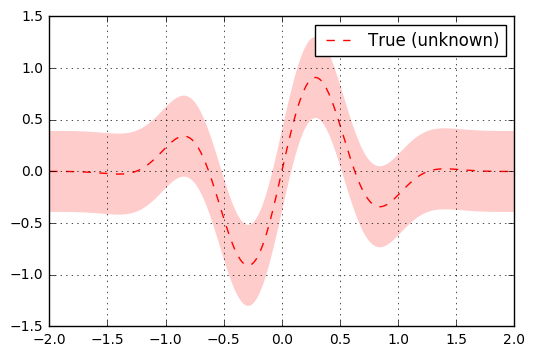

In [20]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

Bayesian optimization based on gaussian process regression is implemented in `skopt.gp_minimize` and can be carried out as follows:

In [27]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=50,         # the number of evaluations of f 
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=123)   # the random seed

res = forest_minimize()

Accordingly, the approximated minimum is found to be:

In [22]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=-0.1998, f(x^*)=-1.1326'

For further inspection of the results, attributes of the `res` named tuple provide the following information:

- `x` [float]: location of the minimum.
- `fun` [float]: function value at the minimum.
- `models`: surrogate models used for each iteration.
- `x_iters` [array]: location of function evaluation for each
   iteration.
- `func_vals` [array]: function value for each iteration.
- `space` [Space]: the optimization space.
- `specs` [dict]: parameters passed to the function.

In [23]:
print(res)

          fun: -1.1326344629946423
    func_vals: array([-0.34357456,  0.49151315,  0.11448457,  0.6506089 , -0.52638972,
       -0.00207713, -0.53060985,  0.16744727,  0.13892541, -0.03697271,
        0.16115168, -0.37282894, -0.33189986,  0.26863806, -0.3375721 ,
       -0.64751646, -0.49120346, -0.25608394, -0.53376253,  0.42055749,
        0.32866817, -0.46520904, -0.42985947, -0.85733707, -0.97517696,
       -0.92867218, -0.75613339, -0.69037177, -0.58058333, -0.73006098,
       -0.39850103, -0.43308154, -0.28897841,  0.0081791 ,  0.35967317,
       -0.6527229 , -0.62168327,  0.24076033, -1.119217  , -0.28790508,
        0.38923797, -0.12937751, -0.16052551,  0.86027949, -0.89367784,
       -0.53425061, -0.77637118, -0.87136791, -1.13263446, -0.8870684 ])
       models: [GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
             n_restarts_optimizer=2, noise=0.010000000000000002,
  

Together these attributes can be used to visually inspect the results of the minimization, such as the convergence trace or the acquisition function at the last iteration:

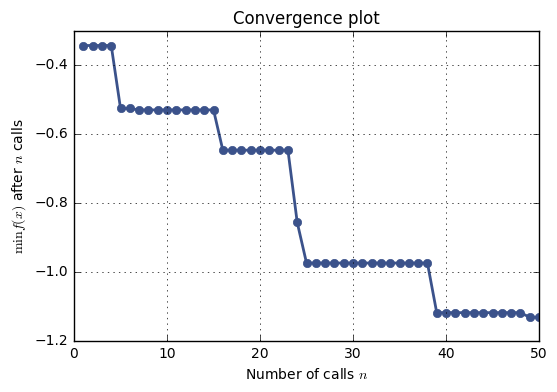

In [24]:
from skopt.plots import plot_convergence
plot_convergence(res);

Let us now visually examine

1. The approximation of the fit gp model to the original function.
2. The acquistion values that determine the next point to be queried.

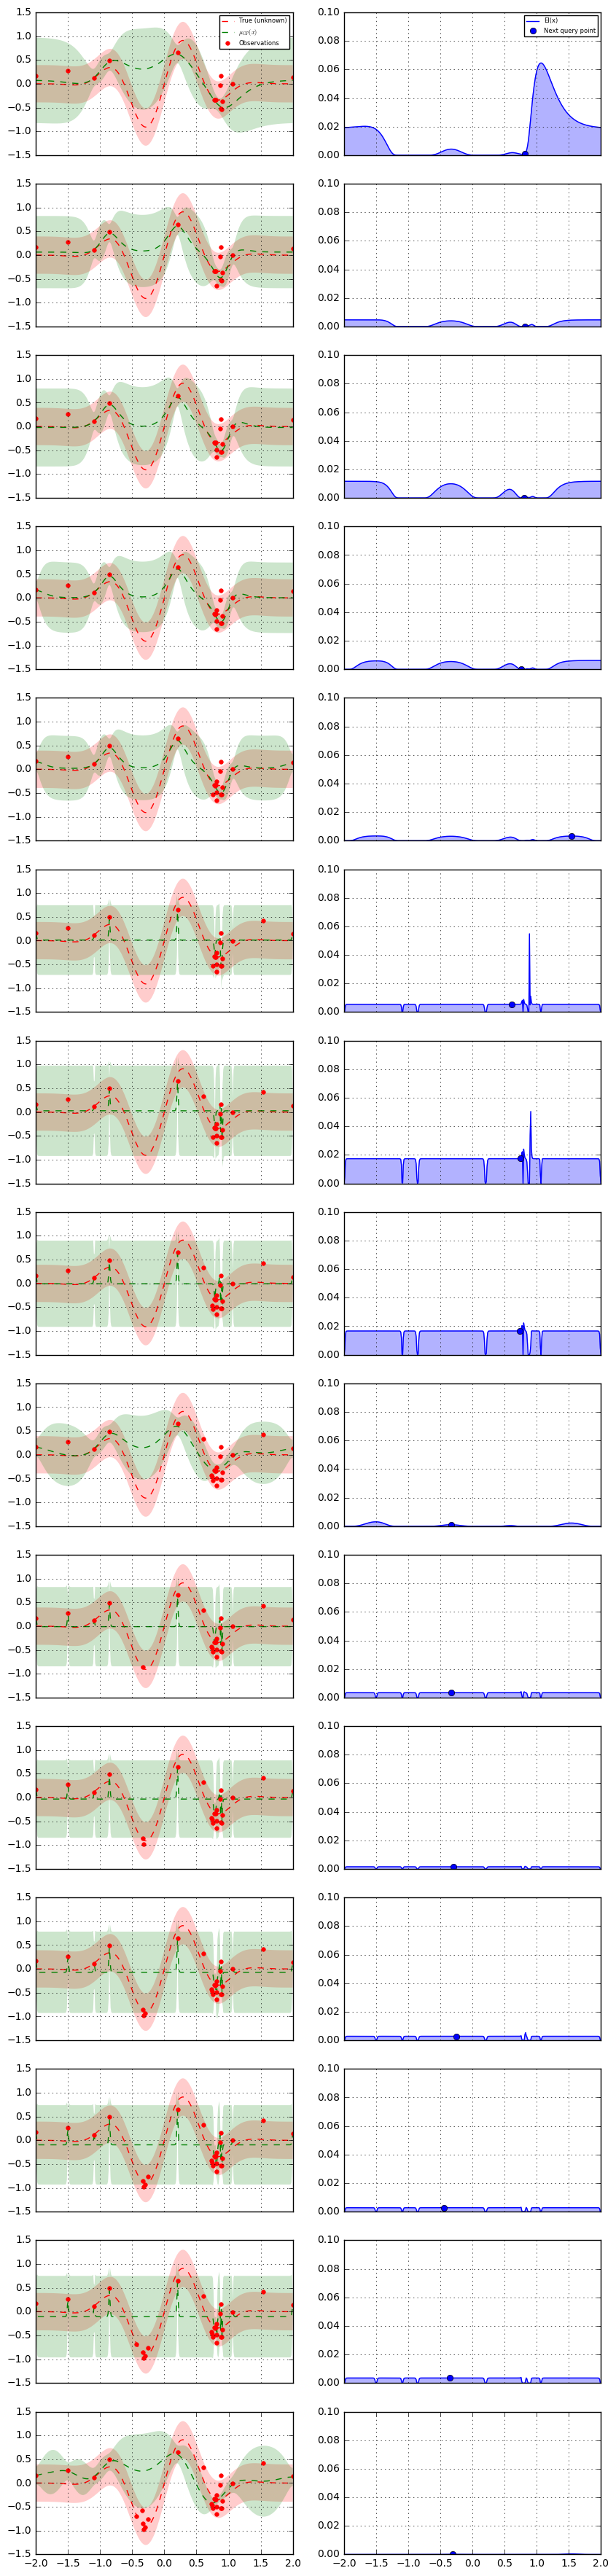

In [25]:
from skopt.acquisition import gaussian_ei

n_plot = 30
n_start = 15
plt.rcParams["figure.figsize"] = (10, 3*(n_plot-n_start))

x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())
fx = np.array([f(x_i, noise_level=0.0) for x_i in x])

# Plot the 5 iterations following the 5 random points
for n_iter in range(n_plot - n_start):
    gp = res.models[n_iter]
    curr_x_iters = res.x_iters[:n_start+n_iter]
    curr_func_vals = res.func_vals[:n_start+n_iter]

    # Plot true function.
    plt.subplot(n_plot-n_start, 2, 2*n_iter+1)
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * noise_level, 
                             fx[::-1] + 1.9600 * noise_level]),
             alpha=.2, fc="r", ec="None")

    # Plot GP(x) + contours
    y_pred, sigma = gp.predict(x_gp, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, 
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(curr_x_iters, curr_func_vals,
             "r.", markersize=8, label="Observations")
    
    # Adjust plot layout
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)
        
    if n_iter != n_plot - n_start -1:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

    # Plot EI(x)
    plt.subplot(n_plot-n_start, 2, 2*n_iter+2)
    acq = gaussian_ei(x_gp, gp, y_opt=np.min(curr_func_vals))
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')
    
    next_x = res.x_iters[n_start+n_iter]
    next_acq = gaussian_ei(res.space.transform([next_x]), gp, y_opt=np.min(curr_func_vals))
    plt.plot(next_x, next_acq, "bo", markersize=6, label="Next query point")
    
    # Adjust plot layout
    plt.ylim(0, 0.1)
    plt.grid()
    
    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)
        
    if n_iter != n_plot - n_start - 1:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

plt.show()

The first column shows the following:

1. The true function.
2. The approximation to the original function by the gaussian process model
3. How sure the GP is about the function.

The second column shows the acquisition function values after every surrogate model is fit. It is possible that we do not choose the global minimum but a local minimum depending on the minimizer used to minimize the acquisition function.

At the points closer to the points previously evaluated at, the variance dips to zero. 

Finally, as we increase the number of points, the GP model approaches the actual function. The final few points are clustered around the minimum because the GP does not gain anything more by further exploration:

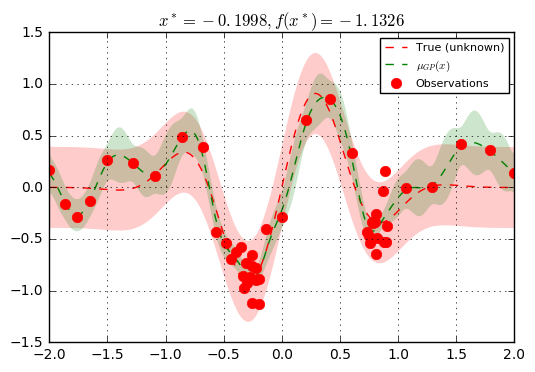

In [26]:
plt.rcParams["figure.figsize"] = (6, 4)

# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())

fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")

# Plot GP(x) + contours
gp = res.models[-1]
y_pred, sigma = gp.predict(x_gp, return_std=True)

plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma, 
                         (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc="g", ec="None")

# Plot sampled points
plt.plot(res.x_iters, 
         res.func_vals, 
         "r.", markersize=15, label="Observations")

plt.title(r"$x^* = %.4f, f(x^*) = %.4f$" % (res.x[0], res.fun))
plt.legend(loc="best", prop={'size': 8}, numpoints=1)
plt.grid()

plt.show()

In [ ]:
from dependence import ImpactOfDependence